In [1]:
#Import library yang diperlukan
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, cross_validate, KFold

In [2]:
#Membuat function untuk menampilkan hasil
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from statsmodel
    :return df: <pandas DataFrame>  combined estimated coefficient and standard error of model estimate
    """
    coef = results.params
    std_err = results.bse
    
    df = pd.DataFrame(data = np.transpose([coef, std_err]), 
                      index = coef.index, 
                      columns=["coef","std err"])
    return df

class StatsmodelsRegressor(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    
    def __init__(self, sm_class, sm_formula):
        self.sm_class = sm_class
        self.sm_formula = sm_formula
        self.model = None
        self.result = None
 
    def fit(self, data, dummy):
        self.model = self.sm_class(self.sm_formula, data)
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)

def kfold_split(data, n_fold):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from statsmodel
    :param n_fold: <int> Number of fold in k-fold CV
    :return df: <pandas DataFrame>  combined estimated coefficient and standard error of model estimate
    """
    kfold = KFold(n_splits = n_fold, 
                  shuffle = True, 
                  random_state=123)
    fold_train = {}
    fold_test = {}

    for i, (train, test) in enumerate(kfold.split(data)):
        print(f"fold {i+1}, train data rows: {len(train)}, test data rows: {len(test)}")
        fold_train[i] = data.iloc[train].copy()
        fold_test[i] = data.iloc[test].copy()
        
    return (fold_train, fold_test)

In [3]:
pm = pd.read_csv('productmanager.csv')


In [4]:
pm

,age,gender,education_level,years_of_experience,salary,country,race,senior
0,42,Female,2,12,120000,USA,Asian,0
1,35,Male,2,7,105000,Canada,Asian,0
2,35,Male,2,10,120000,Canada,White,1
3,27,Male,1,2,40000,USA,Hispanic,0
4,34,Male,1,7,95000,China,Chinese,1
...,...,...,...,...,...,...,...,...
318,32,Male,1,7,120000,Canada,Asian,0
319,25,Male,1,1,60000,Canada,Black,0
320,32,Male,1,7,120000,Australia,Asian,0
321,25,Male,1,1,60000,Australia,White,0


In [5]:
pm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323 entries, 0 to 322
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  323 non-null    int64 
 1   gender               323 non-null    object
 2   education_level      323 non-null    int64 
 3   years_of_experience  323 non-null    int64 
 4   salary               323 non-null    int64 
 5   country              323 non-null    object
 6   race                 323 non-null    object
 7   senior               323 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 20.3+ KB


In [6]:
pm.describe()

,age,education_level,years_of_experience,salary,senior
count,323.000000,323.000000,323.000000,323.000000,323.000000
mean,32.145511,1.504644,7.789474,141021.671827,0.018576
std,4.623113,0.530858,4.167191,48443.309004,0.135231
min,24.000000,1.000000,1.000000,40000.000000,0.000000
25%,29.000000,1.000000,4.000000,110000.000000,0.000000
50%,32.000000,1.000000,7.000000,130000.000000,0.000000
75%,34.000000,2.000000,11.000000,190000.000000,0.000000
max,42.000000,3.000000,14.000000,198000.000000,1.000000


## Mengecek missing value

In [7]:
pm.isna().sum()

age                    0
gender                 0
education_level        0
years_of_experience    0
salary                 0
country                0
race                   0
senior                 0
dtype: int64

In [8]:
pm.duplicated(keep=False).sum()

185

In [9]:
pm = pm.drop_duplicates(keep='first')

In [10]:
pm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203 entries, 0 to 317
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  203 non-null    int64 
 1   gender               203 non-null    object
 2   education_level      203 non-null    int64 
 3   years_of_experience  203 non-null    int64 
 4   salary               203 non-null    int64 
 5   country              203 non-null    object
 6   race                 203 non-null    object
 7   senior               203 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 14.3+ KB


## Deskripsi Data

<Axes: xlabel='age', ylabel='Count'>

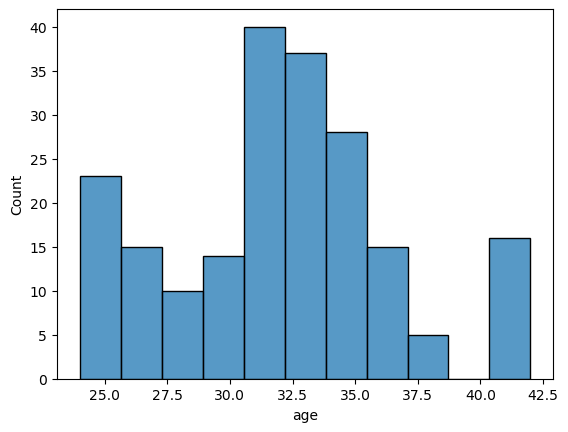

In [11]:
sns.histplot(data=pm,x='age')

In [12]:
pm["age"].describe()

count    203.000000
mean      32.231527
std        4.492082
min       24.000000
25%       29.000000
50%       32.000000
75%       34.000000
max       42.000000
Name: age, dtype: float64

In [13]:
pm["gender"].value_counts()

gender
Male      129
Female     74
Name: count, dtype: int64

In [14]:
pm["education_level"].value_counts()

education_level
1    106
2     92
3      5
Name: count, dtype: int64

<Axes: xlabel='years_of_experience', ylabel='Count'>

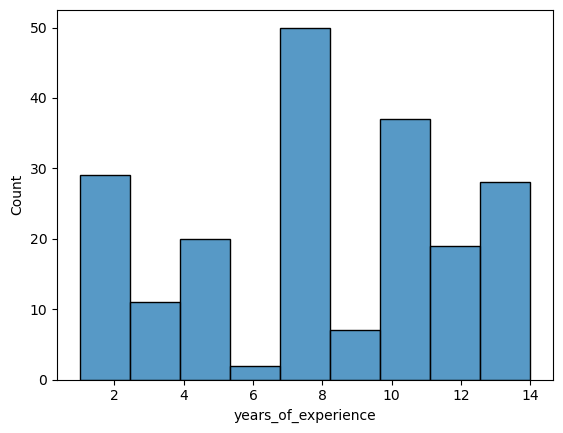

In [15]:
sns.histplot(data=pm,x='years_of_experience')

In [16]:
pm["years_of_experience"].describe()

count    203.000000
mean       7.921182
std        4.137931
min        1.000000
25%        4.000000
50%        8.000000
75%       11.000000
max       14.000000
Name: years_of_experience, dtype: float64

<Axes: xlabel='salary', ylabel='Count'>

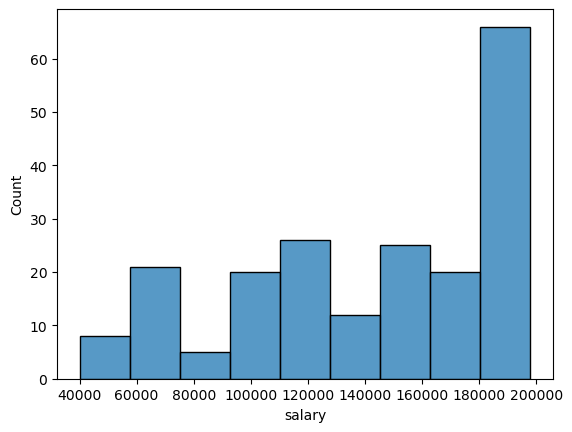

In [17]:
sns.histplot(data=pm,x='salary')

In [18]:
pm["salary"].describe()

count       203.000000
mean     143615.763547
std       47859.428526
min       40000.000000
25%      110000.000000
50%      150000.000000
75%      190000.000000
max      198000.000000
Name: salary, dtype: float64

In [19]:
pm["country"].value_counts()

country
USA          45
Australia    44
China        39
UK           38
Canada       37
Name: count, dtype: int64

In [20]:
pm["race"].value_counts()

race
Asian               52
White               52
Korean              17
Australian          17
Chinese             12
Mixed               12
African American    11
Hispanic            10
Black               10
Welsh               10
Name: count, dtype: int64

In [21]:
pm["senior"].value_counts()

senior
0    197
1      6
Name: count, dtype: int64

## Membangun model regresi dengan satu variabel prediktor

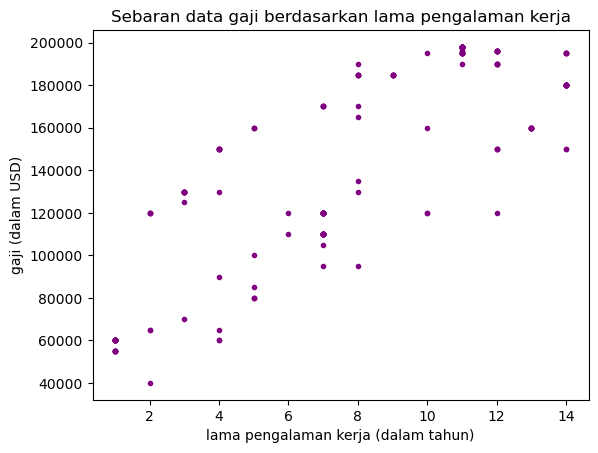

In [22]:
x = pm["years_of_experience"]
y = pm["salary"]

# Plot the data
plt.scatter(x, y, color = "purple", marker=".")

# Add a legend and labels
plt.xlabel("lama pengalaman kerja (dalam tahun)")
plt.ylabel("gaji (dalam USD)")

# Add a title and adjust the margins
plt.title("Sebaran data gaji berdasarkan lama pengalaman kerja")

# Show the plot
plt.show()

In [23]:
# Create OLS model object
model = smf.ols("salary ~ years_of_experience", pm)

# Fit the model
results_1V = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_1 = print_coef_std_err(results_1V)
results_1

,coef,std err
Intercept,68866.468031,4213.308302
years_of_experience,9436.633700,471.701627


In [24]:
results_1V.rsquared

0.6656801223369674

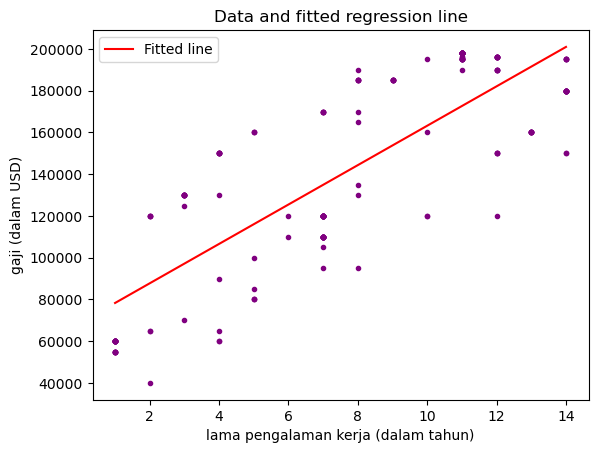

In [25]:
predictor = "years_of_experience"
outcome = "salary"
data = pm.copy()

# Plot the data
plt.scatter(data[predictor], data[outcome], color = "purple", marker=".")

# Calculate the fitted values
a_hat = results_1.loc["Intercept"]["coef"]
b_hat = results_1.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 10000)

fitted_values = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted line", color = "red")

# Add a legend and labels
plt.legend()
plt.ylabel("gaji (dalam USD)")
plt.xlabel("lama pengalaman kerja (dalam tahun)")

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

## Membangun model regresi dengan dua variabel prediktor

In [26]:
# Create OLS model object
model = smf.ols("salary ~ years_of_experience+age", pm)

# Fit the model
results_2V = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_2 = print_coef_std_err(results_2V)
results_2

,coef,std err
Intercept,279208.817875,21288.135017
years_of_experience,17960.022305,934.645185
age,-8620.679489,860.958617


In [27]:
results_2V.rsquared

0.7773114919766972

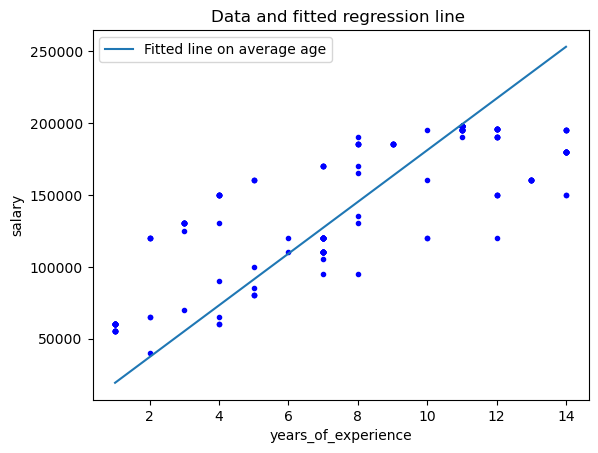

In [28]:
predictors = ["years_of_experience","age"]
outcome = "salary"
data = pm
results_ = results_2

# Plot the data
plt.scatter(data[predictors[0]], data[outcome], color = "blue", marker=".")


# x value as mom_iq predictors value
x_domain = np.linspace(np.min(data[predictors[0]]), np.max(data[predictors[0]]), 100)

# Calculate the fitted values for two lines regarding the mom_hs (0 and 1)
beta0_hat = results_.loc["Intercept"]["coef"]
beta1_hat = results_.loc[predictors[0]]["coef"]
beta2_hat = results_.loc[predictors[1]]["coef"]

fitted_values = beta0_hat +  beta1_hat * x_domain  + beta2_hat * data[predictors[1]].mean()

# Plot two fitted line
plt.plot(x_domain, fitted_values, label = f"Fitted line on average age")

# Add a legend and labels
plt.legend()
plt.ylabel(f"{outcome}")
plt.xlabel(f"{predictors[0]}")

# Add a title and adjust the margins
plt.title("Data and fitted regression line ")

# Show the plot
plt.show()

In [29]:
#Melakukan centering pada kolom age
age = pm['age']

pm['c_age'] = (age - np.mean(age))

C:\Users\JAYA GENTENG\AppData\Local\Temp\ipykernel_6488\1574480336.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm['c_age'] = (age - np.mean(age))


In [30]:
np.mean(age)

32.23152709359606

In [31]:
pm.head()

,age,gender,education_level,years_of_experience,salary,country,race,senior,c_age
0,42,Female,2,12,120000,USA,Asian,0,9.768473
1,35,Male,2,7,105000,Canada,Asian,0,2.768473
2,35,Male,2,10,120000,Canada,White,1,2.768473
3,27,Male,1,2,40000,USA,Hispanic,0,-5.231527
4,34,Male,1,7,95000,China,Chinese,1,1.768473


In [32]:
# Create OLS model object
model = smf.ols("salary ~ years_of_experience+c_age", pm)

# Fit the model
results_2VB = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_age_yoe = print_coef_std_err(results_2VB)
results_age_yoe

,coef,std err
Intercept,1351.153364,7572.947949
years_of_experience,17960.022305,934.645185
c_age,-8620.679489,860.958617


In [33]:
results_2VB.rsquared

0.7773114919766972

## Membangun model regresi dengan tiga variabel

In [34]:
#Menghitung rata-rata gaji berdasarkan gender
pm.groupby(["gender"])[["salary"]].mean()

,salary
gender,
Female,164459.459459
Male,131658.914729


In [35]:
#Menambahkan kolom baru gender dalam format angka. 0 = Female, 1 = Male
pm["gender_n"]=pm["gender"].map({"Female":0,"Male":1})

C:\Users\JAYA GENTENG\AppData\Local\Temp\ipykernel_6488\1161903516.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm["gender_n"]=pm["gender"].map({"Female":0,"Male":1})


In [36]:
pm.head()

,age,gender,education_level,years_of_experience,salary,country,race,senior,c_age,gender_n
0,42,Female,2,12,120000,USA,Asian,0,9.768473,0
1,35,Male,2,7,105000,Canada,Asian,0,2.768473,1
2,35,Male,2,10,120000,Canada,White,1,2.768473,1
3,27,Male,1,2,40000,USA,Hispanic,0,-5.231527,1
4,34,Male,1,7,95000,China,Chinese,1,1.768473,1


In [37]:
# Create OLS model object
model = smf.ols("salary ~ years_of_experience+c_age+gender_n", pm)

# Fit the model
results_3VA = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_3V1 = print_coef_std_err(results_3VA)
results_3V1

,coef,std err
Intercept,19192.910916,9347.988270
years_of_experience,16608.947115,1011.344104
c_age,-7417.904382,925.998445
gender_n,-11235.254854,3587.429366


In [38]:
results_3VA.rsquared

0.7877719074120972

## Melakukan K-Fold Cross Validation

In [39]:
# Create a class model

ols_all_media = StatsmodelsRegressor(smf.ols, "salary ~ years_of_experience+c_age+gender_n")

In [40]:
# Create k-fold splitter object

kfold = KFold(n_splits=3, shuffle = True, random_state=123)

In [41]:
scores_ols_all_media = cross_val_score(estimator = ols_all_media,
                                       X = pm,
                                       y = pm["salary"],
                                       cv = kfold,
                                       scoring = "r2")
scores_ols_all_media = pd.DataFrame(data = scores_ols_all_media, 
                                    columns=["test_rsquared"])
scores_ols_all_media["folds"] = [f"Folds {i+1}" for i in range(3)]
scores_ols_all_media

,test_rsquared,folds
0,0.819925,Folds 1
1,0.770175,Folds 2
2,0.699284,Folds 3


In [42]:
scores_ols_all_media["test_rsquared"].mean()

0.7631282113332875

In [43]:
intercept = results_3V1["coef"]["Intercept"]
co_yo_exp = results_3V1["coef"]["years_of_experience"]
co_age = results_3V1["coef"]["c_age"]
co_gender = results_3V1["coef"]["gender_n"]

In [44]:
test = pd.read_csv('test.csv')

In [45]:
test

,Name,Age,Years_of_experience,Gender,Education Level,Country
0,Ester,32,6,Female,2,USA
1,Philip,36,8,Male,3,Australia
2,Peter,40,12,Male,2,UK
3,Xiang,26,3,Female,1,China
4,Erick,45,20,Male,1,Canada


In [46]:
test

,Name,Age,Years_of_experience,Gender,Education Level,Country
0,Ester,32,6,Female,2,USA
1,Philip,36,8,Male,3,Australia
2,Peter,40,12,Male,2,UK
3,Xiang,26,3,Female,1,China
4,Erick,45,20,Male,1,Canada


In [47]:
#Mengubah gender menjadi variabel biner
test["Gender_n"]=test["Gender"].map({"Female":0,"Male":1})

In [48]:
test["estimated_salary"] = intercept + \
                             (co_yo_exp * test["Years_of_experience"]) + \
                             (co_age * (test["Age"]-32)) + \
                             (co_gender * test["Gender_n"])

In [49]:
test

,Name,Age,Years_of_experience,Gender,Education Level,Country,Gender_n,estimated_salary
0,Ester,32,6,Female,2,USA,0,118846.593603
1,Philip,36,8,Male,3,Australia,1,111157.615451
2,Peter,40,12,Male,2,UK,1,147921.786381
3,Xiang,26,3,Female,1,China,0,113527.178551
4,Erick,45,20,Male,1,Canada,1,243703.841388
